In [88]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchaudio.transforms as T

import torchaudio

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [89]:
df = pd.read_csv('../data/UrbanSound8K/slices_2d/slice_2d_filenames.csv')
df.head()

,Unnamed: 0,file_path,classid
0,0,../data/UrbanSound8K/slices_2d/fold1/46654-6-0...,6
1,1,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
2,2,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
3,3,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0
4,4,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0


In [90]:
len(df['classid'].unique())

10

In [91]:
df['fold'] = [int(text[-2][-1]) for text in df['file_path'].str.split('/')]

In [92]:
df.head()

,Unnamed: 0,file_path,classid,fold
0,0,../data/UrbanSound8K/slices_2d/fold1/46654-6-0...,6,1
1,1,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
2,2,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
3,3,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1
4,4,../data/UrbanSound8K/slices_2d/fold1/57320-0-0...,0,1


In [93]:
class UrbanSoundDataset_Aug(Dataset):
    def __init__(self, df, Aug=True):
        self.df = df
        self.Aug = Aug
        self.fade = T.Fade(fade_in_len=1, fade_out_len=1, fade_shape='quarter_sine')
        self.freq_masking = T.FrequencyMasking(freq_mask_param=2)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = np.load(row['file_path'])
        x = torch.tensor(x).float()
        
        if self.Aug:
            x = self.fade(x)
            x = self.freq_masking(x)
            
        y = torch.tensor(row['classid'])
        return x, y
        

In [94]:
df_train = df[df['fold'] < 8]

In [95]:
df_val = df.drop(df_train.index)

In [96]:
df_train.shape[0], df_val.shape[0], df.shape[0]

(36175, 8100, 44275)

In [97]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        
        self.linear1 = nn.Linear(512, 100)
        self.linear2 = nn.Linear(100, 10)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.flatten = nn.Flatten()
        
        self.dropout = nn.Dropout2d(p=0.2)
        
        
    def forward(self, x):
        # helpful to do this along the way sometimes!
        #print(x.shape)
        
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.pool(x)

        x = self.dropout(x)
        x = self.flatten(x)
        
        # unroll x for FC layer
        x = self.linear1(self.flatten(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [98]:
model = CNN()
from torchsummary import summary
summary(model, input_size = (32, 16, 2), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 17, 3]           8,256
              Tanh-2            [-1, 64, 17, 3]               0
         MaxPool2d-3             [-1, 64, 8, 1]               0
            Conv2d-4            [-1, 128, 9, 2]          32,896
              Tanh-5            [-1, 128, 9, 2]               0
         MaxPool2d-6            [-1, 128, 4, 1]               0
         Dropout2d-7            [-1, 128, 4, 1]               0
           Flatten-8                  [-1, 512]               0
           Flatten-9                  [-1, 512]               0
           Linear-10                  [-1, 100]          51,300
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 93,462
Trainable params: 93,462
Non-trainable params: 0
---------------------------------

In [99]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_acc = []
    
    softmax = nn.Softmax(dim=1)
    
    for x, y in dataloader:
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        acc = 1 - (torch.count_nonzero(y - y_pred).item() / y.shape[0])
        
        total_acc.append(acc)
        
    return round(np.mean(total_acc),2)

In [100]:
from tqdm.notebook import tqdm
def train_epoch(num_epochs, model, dl_train1, dl_train2, dl_val, optimizer, lossFun, ds_train1, ds_train2, ds_val):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: ', epoch)

        train_loss = one_pass(model, dl_train1, optimizer, lossFun)
        train_losses.append(train_loss)
        print('Train loss: ', train_loss)

        train_loss = one_pass(model, dl_train2, optimizer, lossFun)
        train_losses.append(train_loss)
        print('Train loss: ', train_loss)
        
        valid_loss = one_pass(model, dl_val, optimizer, lossFun, backwards=False)
        valid_losses.append(valid_loss)
        print('Valid loss: ', valid_loss)

        train_acc = one_pass_acc(model, dl_train2, len(ds_train2))
        train_accs.append(train_acc)
        
        valid_acc = one_pass_acc(model, dl_val, len(ds_val))
        valid_accs.append(valid_acc)
        print('Train Acc: ', train_acc)
        print('Valid Acc: ', valid_acc)
    
    return train_losses, valid_losses, train_accs, valid_accs
    

In [101]:
import seaborn as sns

In [102]:
def plot_results(train_loss, val_loss, train_acc, val_acc):
    sns.set_theme()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Losses')
    axes[0].legend()
    
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()

In [103]:
ds_train_Aug = UrbanSoundDataset_Aug(df_train, Aug=True)
ds_train_No_Aug = UrbanSoundDataset_Aug(df_train, Aug=False)
ds_val = UrbanSoundDataset_Aug(df_val, Aug=False)
dl_train_Aug = DataLoader(ds_train_Aug, batch_size=100, shuffle=True)
dl_train_No_Aug = DataLoader(ds_train_No_Aug, batch_size=100, shuffle=True)
dl_val = DataLoader(ds_train, batch_size=100, shuffle=False)

In [104]:
num_epoch = 10
model = CNN()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
lossFun = nn.CrossEntropyLoss()

train_losses, valid_losses, train_accs, valid_accs = train_epoch(num_epoch, model, 
                                                                 dl_train_Aug, 
                                                                 dl_train_No_Aug,
                                                                 dl_val, 
                                                                 optimizer, 
                                                                 lossFun, 
                                                                 ds_train_Aug,
                                                                 ds_train_No_Aug,
                                                                 ds_val)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.809145790766616


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.4183488135838378


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  2.4978619599869236
Train Acc:  0.56
Valid Acc:  0.18
Epoch:  1


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.3291515210715448


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.0833101463581316


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  2.08678853100176
Train Acc:  0.67
Valid Acc:  0.3
Epoch:  2


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  1.1251022598361442


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.889771246943026


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  1.5174834767757859
Train Acc:  0.74
Valid Acc:  0.48
Epoch:  3


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.9716543989945512


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.7531281191835087


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  1.1000095488534447
Train Acc:  0.78
Valid Acc:  0.63
Epoch:  4


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.8491923621346279


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.6393408644429887


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  0.9112293078919143
Train Acc:  0.81
Valid Acc:  0.69
Epoch:  5


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.7631844119143091


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.5525670349597931


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  0.7785681903526928
Train Acc:  0.84
Valid Acc:  0.73
Epoch:  6


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.6809709128918568


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.4847366200626226


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  0.7426001136885823
Train Acc:  0.86
Valid Acc:  0.75
Epoch:  7


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.6240916151697464


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.4339557311482192


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  0.6752111354832491
Train Acc:  0.88
Valid Acc:  0.76
Epoch:  8


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.5740009713403428


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.391314042989391


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  0.6696286350488663
Train Acc:  0.9
Valid Acc:  0.76
Epoch:  9


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.5326901144085668


  0%|          | 0/362 [00:00<?, ?it/s]

Train loss:  0.3514014553710901


  0%|          | 0/362 [00:00<?, ?it/s]

Valid loss:  0.6462956727971194
Train Acc:  0.91
Valid Acc:  0.77


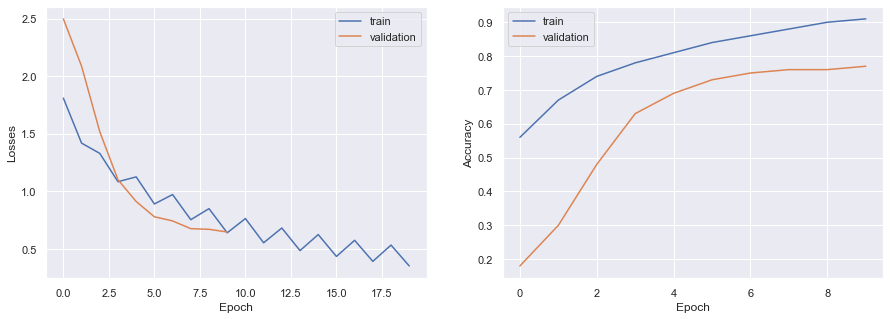

In [105]:
plot_results(train_losses, valid_losses, train_accs, valid_accs)

In [106]:
train_losses

[1.809145790766616,
 1.4183488135838378,
 1.3291515210715448,
 1.0833101463581316,
 1.1251022598361442,
 0.889771246943026,
 0.9716543989945512,
 0.7531281191835087,
 0.8491923621346279,
 0.6393408644429887,
 0.7631844119143091,
 0.5525670349597931,
 0.6809709128918568,
 0.4847366200626226,
 0.6240916151697464,
 0.4339557311482192,
 0.5740009713403428,
 0.391314042989391,
 0.5326901144085668,
 0.3514014553710901]

In [108]:
train_avg = []
for i in range(0, len(train_losses), 2):
    avg = (train_losses[i] + train_losses[i+1]) / 2 
    train_avg.append(avg)

In [109]:
train_avg

[1.6137473021752269,
 1.2062308337148382,
 1.0074367533895852,
 0.8623912590890299,
 0.7442666132888083,
 0.6578757234370511,
 0.5828537664772397,
 0.5290236731589828,
 0.4826575071648669,
 0.4420457848898285]

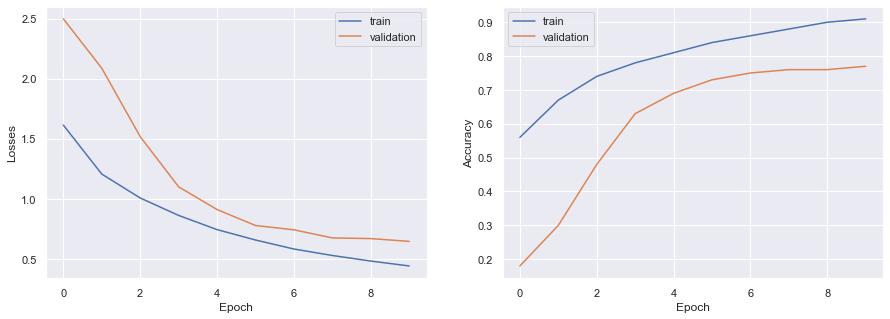

In [110]:
plot_results(train_avg, valid_losses, train_accs, valid_accs)

In [111]:
def plot_results(train_loss, val_loss, train_acc, val_acc, save=False):
    sns.set_theme()
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Losses')
    axes[0].legend()
    
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    if save:
        plt.savefig('3d_with_augmentation', dpi=150)

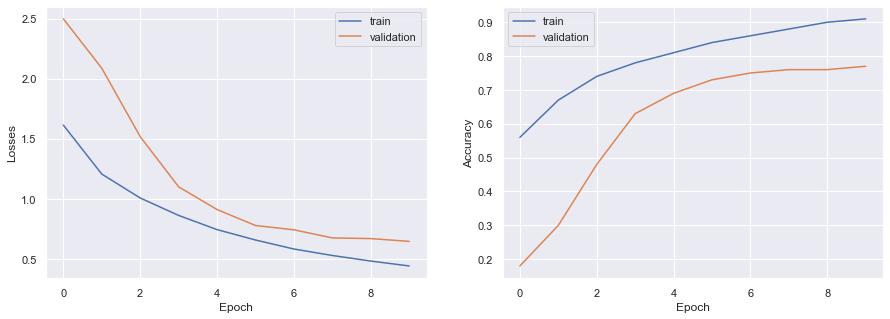

In [113]:
plot_results(train_avg, valid_losses, train_accs, valid_accs, save=True)